# Reconnaissance d’auteur d’œuvres littéraires à partir du graphe d’interactions de leurs personnages

_Ce projet a été développé dans le cadre du MS Big Data à Télécom Paris, pour le cours SD701, donné par Louis Jachiet et Tiphaine Viard_.

__Objectif général__

L'objectif de ce projet est de détecter l'auteur d'une oeuvre littéraire, sur la base de l'analyse des interactions des personnages du roman.  
L'hypothèse générale, développée par [1], est qu'au delà de son style littéraire, un écrivain est reconnaissable par le type d'intrigue qu'il crée pour ses oeuvres. En partant du postulat qu'un roman est une "socitété en miniature", on dépeind l'intrigue via un __graphe d'interactions entre personnages__, duquel on tente de déduire la paternité de l'oeuvre.  
En m'inspirant de cette démarche, je tente de construire une version pour la littérature française, d'un outils automatique de détection d'auteur.

[1]_Mariona Coll Ardanuy and Caroline Sporleder. "Structure-based Clustering of Novels", The 3rd Workshop on Computational Linguistics for Literature, 2014._ 

## Libraries

In [2]:
import nltk
from nltk import bigrams
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

import spacy
import fr_core_news_sm

import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from collections import Counter
import pandas as pd
import numpy as np
import itertools
import collections
import string

import networkx as nx

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
sns.set_theme()

In [2]:
# French version with Spicy
spacy.load('/Users/simondelarue/opt/anaconda3/lib/python3.7/site-packages/fr_core_news_sm/fr_core_news_sm-2.3.0')

## Import   
Les oeuvres litteraires sont issues de 'Project Gutenberg', une librairie en ligne gratuite fondée par Michael Hart, l'inventeur du eBook.   
http://gutenberg.org/about/

In [3]:
%%time
path = '/Users/simondelarue/Documents/MS_BGD-Telecom_PARIS/SD701_Exploration_Donnees/Projet/input/'
file_dict = {}
for file in os.listdir(path):
    if file not in ['.DS_store', '.DS_Store']:
        file_dict[file.split('_')[0]] = file_dict.get(file.split('_')[0], []) + [file]

CPU times: user 649 µs, sys: 1.04 ms, total: 1.69 ms
Wall time: 755 µs


In [4]:
def read_file(file):
    return open(path + file, 'r')

## Data Preprocessing

### Tokenisation   
Le texte est transformé en liste de mots.

In [5]:
# Import de la ponctuation depuis la librairie string
punctuations = list(string.punctuation)

def tokenize(file, ponctuation):
    ''' Tokenize un texte sans prendre en compte la ponctuation '''
    
    tokenized_file = [word for word in word_tokenize(file.read().replace('\n', ' ')) if word not in ponctuation]
    #len(tokenized_file)
    return tokenized_file

### Stopwords   
Un stopword, ou "mot vide", est un mot non significatif dans le texte, qu'il n'est pas utile d'indexer  (i.e sa distribution est uniforme sur une collection de textes).   
Afin d'alléger la liste de mots créée pour chacun des textes passés en revue, les stopwords sont otés.   
Après analyse des résultats, on remarque que les pronoms personnels peuvent également être considérés comme des Personnes. Dans l'exercice qui suit, on décide des les oter. Néanmoins, dans une approche plus détaillée, il pourrait être intéressant de prendre en compte ces données, notamment pour extraire des informations sur les conversations entre personnages.

In [6]:
# Download stopwords from nltk
nltk_stopwords_fr = nltk.corpus.stopwords.words('french')
print('# of NLTK stopwords : ', len(nltk_stopwords_fr))

# Download stopwords from Spacy
spacy_stopwords_fr = spacy.lang.fr.stop_words.STOP_WORDS
print('# of Spacy stopwords : ', len(spacy_stopwords_fr))

# Spacy + nltk stopwords
spacyNltk_stopwords_fr = list(nltk_stopwords_fr) + list(spacy_stopwords_fr)

# Liste des pronoms personnels français
pronoms_pers_fr = ['je', 'Je', 'tu', 'Tu', 'il', 'Il', 'elle', 'Elle', 'nous', 'Nous', 'vous', \
                   'Vous', 'ils', 'Ils']
print('# of pronoms personnels : ', len(pronoms_pers_fr))

# of NLTK stopwords :  157
# of Spacy stopwords :  600
# of pronoms personnels :  14


In [7]:
def clean_text(tokenized_file, stopwords, pronoms):
    ''' Nettoie un texte tokenisé des stopwords et des pronoms '''
    
    # Les mots collés à de la ponctuation pourraient gêner. On traite ce problème
    cleaned_text = [re.findall('[A-Za-zÀ-ÿ0-9]+', mot) for mot in tokenized_file]
    cleaned_text = [item for sublist in cleaned_text for item in sublist]

    # On retire les stopwords du texte, ainsi que les pronoms personnels
    cleaned_text = [x for x in cleaned_text if x not in stopwords and x not in pronoms]

    return cleaned_text

### Named Entity Recognition (NER)   
L'algorithme de NER (CNN) permet d'associer à chaque mot une catégorie grammaticale. La librairie utilisée ici (Spacy) classe chaque mot rencontré en 4 catégories distinctes :
 - 'PER' : Personne ; c'est la catégorie qui sera utilisée pour représenter le réseau de personnages de l'oeuvre
 - 'LOC' : Lieu défini géographiquement ou politiquement (ville, province, pays région, montagnes, etc)
 - 'ORG' : Organisation, entreprise, entité
 - 'MISC': Divers

In [8]:
# Import de l'algorithme de TAG
nlp_fr = fr_core_news_sm.load()

def tagging(text):
    ''' Application d'un algorithme de TAG permettant de classer les mots du texte en catégories 
        Renvoie une liste de tuples (mot, TAG)'''
    
    doc = nlp_fr(' '.join(text))
    labels = [(word.text, word.label_) for word in doc.ents]
    return labels

Le TAG peut s'appliquer sur plusieurs mots. Dans ce cas, on choisit le mot de la liste avec la plus grande taille. Cela permet d'écarter les titres des personnages par exemple.   

In [9]:
def maxsize_elem_in_list(text):
    ''' Renvoie l'élément le plus grand d'un ensemble de mots '''
    return max(text.split(' '), key=len)

def clean_tag(tagged_text):
    ''' Nettoie les TAG appliqués à plusieurs mots. 
        Le texte taggé en paramètre est une liste de tuple '''
    
    # Dataframe avec les mots et leur(s) TAG(s) nettoyés
    TAG_df = pd.DataFrame(tagged_text, columns = ['Name', 'TAG'])
    TAG_df["cleanName"] = TAG_df["Name"].apply(maxsize_elem_in_list)
    del TAG_df['Name']
    
    return TAG_df

__Analyse des TAG créés__

Analyse des tags sur la base de ceux notés PER => pour chaque PER du texte, quelle est la distribution de notation de l'élément dans les autres catégories ?

In [10]:
def count_tags(caracter_tuples):
    """ input : list of tuples of a caracter's tag
        output : return the count of each tags for the caracter """
    tag_counter = Counter(label[1] for label in caracter_tuples) 
    return tag_counter

def plot_hist_tags(tag_counter):
    """ input : count of tags for a caracter
        display histogram of tags """
    df = pd.DataFrame.from_dict(tag_counter, orient='index')
    df.plot(kind='bar', legend=False)
    plt.xlabel('Classes')
    plt.ylabel('Fréquence')
    
def calculate_tags_ratios(tag_counter, caracter_tuples):
    """ input : tag_counter
        output : display ratios of the count of tags """
    somme = sum(tag_counter[elem] for elem in tag_counter if elem != 'PER')
    print('% de mal classés pour le nom {} : {:.2%}'.format(caracter_tuples[0][1], somme/len(caracter_tuples)))
    print('% de bien classés pour le nom {} : {:.2%}\n'.format(caracter_tuples[0][1], 1-(somme/len(caracter_tuples))))

**Correction des tags pour les personnages (PER)**

On fixe un treshold à 50%. Si pour un personnage donné, la proportion d'apparition d'un de ses tags dépasse le treshold, on force ce tag pour toutes les occurences du personnage.

In [11]:
def clean_df_TAG(df, treshold):
    ''' Harmonisation des TAG pour un même élément 
        Le DataFrame en paramètre est issu de la fonction clean_tag() 
        Le treshold est le seuil au delà duquel la catégorie de TAG est 
        considérée comme maitresse '''
    
    # Compte de le nombre de TAG par personnage et par catégorie de TAG
    df_name_count = df[['cleanName','TAG']].groupby(['cleanName', 'TAG'])['TAG'].count() \
                    .reset_index(name='count_TAG') \
                    .sort_values(['count_TAG'], ascending=False)


    # Compte le nombre de TAG possible pour un personnage
    df_name_count_tot = df_name_count[['cleanName','count_TAG']] \
                        .groupby(['cleanName'])['count_TAG'].sum() \
                        .reset_index(name='count_TAG_tot') \
                        .sort_values(['count_TAG_tot'], ascending=False)

    # Calcul des répartitions des TAG pour chaque personnage
    df_name_count_join = pd.merge(df_name_count, df_name_count_tot, how='left')
    df_name_count_join['Poids_TAG'] = df_name_count_join['count_TAG'] / df_name_count_join['count_TAG_tot']

    # Création du TAG définitif en fonction du poids des TAG initiaux
    df_name_count_join['TAG_definitif'] = np.where(df_name_count_join['Poids_TAG'] >= treshold \
                                                   , df_name_count_join['TAG'] \
                                                   , np.nan)
    df_name_TAG_def = df_name_count_join[['cleanName', 'TAG_definitif']].drop_duplicates()
    df_name_TAG_def = df_name_TAG_def.dropna()
    
    del df_name_count_join['TAG_definitif']
    del df_name_count_join['TAG']
    del df_name_count_join['count_TAG_tot']
    del df_name_count_join['Poids_TAG']
    
    df_name_count_join = pd.merge(df_name_count_join, df_name_TAG_def, how='left')
    df_name_count_join = df_name_count_join.groupby(['cleanName', 'TAG_definitif'])['count_TAG'] \
                        .sum().reset_index()

    # Conserve uniquement les éléments taggés PER (personnages du texte)
    cleaned_names_df = df_name_count_join[df_name_count_join['TAG_definitif'] == 'PER'] \
                        .sort_values(['count_TAG'], ascending=False)
    # Conserve uniquement les éléments dont la 1ère lettre est en majuscule
    cleaned_names_df = cleaned_names_df.loc[cleaned_names_df['cleanName'].apply(lambda x: x[0].isupper())]
    
    return cleaned_names_df

La première passe de cleaning des TAG nous donne une vision plus claire des personnages d'un texte. Néanmoins, ce type d'algorithme n'est pas parfait et les règles de gestion définies ci-dessus peuvent altérer les résultats initiaux. Afin d'améliorer encore un peu les résultats, on fait une seconde phase de cleaning sur les TAG, dans laquelle on :  
- réapplique l'algorithme de TAG sur les éléments retenus à ce stade (et on ne retient que ceux classés en PER)  
- Ne retient que les personnages dont la taille du nom est supérieur à deux caractères. 
- exclue les "titres" (Monsieur, Compte, etc)

In [12]:
def second_clean_tag(df, tagged_text):
    
    def find_tag(mot):
        for elem in tagged_text:
            if (mot == elem[0]):
                return elem[1]
            
    def find_title(mot):
        for elem in ['Monsieur', 'Mr', 'Msr', 'Madame', 'Mademoiselle', 'Mme', 'Mlle', 'Compte',
                    'Prince', 'Roi', 'Princesse', 'Reine', 'Duc', 'Duchesse', 'Reine', 'Comptesse']:
            if (mot == elem):
                return True
            else:
                return False
        
    df_second_cleaned = df.copy()
    df_second_cleaned['second_TAG'] = df_second_cleaned['cleanName'].apply(find_tag)
    df_second_cleaned['title_TAG'] = df_second_cleaned['cleanName'].apply(find_title)
    
    df_second_cleaned = df_second_cleaned.loc[
                          (df_second_cleaned['count_TAG'] > 2) & # apparaît plus de 2 fois dans tout le texte
                          (~df_second_cleaned['title_TAG'])] # n'est pas un titre
    
    del df_second_cleaned['second_TAG']
    del df_second_cleaned['title_TAG']
    
    return df_second_cleaned

### Windows of text   
Pour chaque oeuvre, on crée une 'text_window' de taille :  
<center> nombre de mots du texte - (mots exclus) / $x$ </center> 
Où $x$ est défini par l'utilisateur.     

Pour chacune de ces text windows, on créera un graphe d'interractions des personnages. Les données seront ensuite agrégées dans une seule table, récapitulant toute l'oeuvre.   

In [13]:
def text_window(clean_txt, perct_cut):
    ''' Découpe un texte donné en fonction du pourcentage passé en paramètre, et retourne une liste
        des fenêtres de texte '''
    
    pas = round(perct_cut * len(clean_txt))
    text_windows = []
    
    for index in range(0, len(clean_txt), pas):
        text_windows.append([text_window for text_window in clean_txt[index:index + pas - 1]])
    
    return text_windows

def clean_text_window(text_window, clean_names_list):
    ''' Nettoyage des mots obtenus dans la fenêtre de texte '''
    
    return [word for word in text_window if word in clean_names_list and len(word)>3]

### Matrice de cooccurences    
Pour chaque fenêtre de texte, création d'une matrice de coocurences des personnages, représentant leurs interactions dans le passage etudié.

In [14]:
def count_occurences(text_window):
    ''' Sur la base d'une liste de mots passée en paramètre, retourne un dictionnaire
        associant à chaque personnage, la liste des personnages qu'il a rencontré sur l'intervalle de temps,
        avec le nombre d'apparitions pour chacuns d'eux '''
    
    occurences_tot = {}
    text_window_tmp = text_window

    # Parcours de tous les personnages de la text window
    for character in text_window_tmp:
        remaining_chars = text_window_tmp

        # Création de la liste des personnages restants en otant le personnage parcouru
        # à la liste initiale de personnages
        remaining_chars.remove(character)

        # Parcours de la liste des personnage restants et comptage des interractions entre ceux-ci
        # et le personnage parcouru dans la 1ère boucle
        # On ne compte pas les occurences entre le personnage et lui même
        occurences_perso = {}
        for remaining_char in remaining_chars:
            if remaining_char != character:
                occurences_perso[remaining_char] = occurences_perso.get(remaining_char, 0) + 1

        # On affecte toutes ses interractions au personnage
        occurences_tot[character] = occurences_perso 
        
    return occurences_tot

In [15]:
def coocMatrix(text_windows):
    ''' Calcule un dictionnaire de cooccurences pour un ensemble de textes '''
    
    cooc_matrixes = [count_occurences(text_window) for text_window in text_windows]
    return cooc_matrixes

**Matrice de cooccurences to DataFrame**

Matrice de cooccurences sous forme de table "aplatie".   
On crée une nouvelle variable d'agrégation qui ne tient pas compte du sens des interactions (i.e Pers1->Pers2 doit être égale à Pers2->Pers1).

In [16]:
def coocMatrix_to_df(coocMatrix):
    ''' input  : Matrix of cooccurences between characters
        output : DataFrame containing 4 columns :
                - one tuple representing an interraction between two characters
                - the name of the first character in the interraction
                - the name of the second character in the interraction
                - the count of interractions between the two characters in the text window '''
    
    df = pd.DataFrame.from_dict(coocMatrix)
    df = df.reset_index().rename(columns = {'index':'charact1'})
    df = df.melt(id_vars='charact1', var_name='charact2', value_name='nbInteractions')
    df = df.dropna()
    df['charactAgreg'] = np.where(df['charact1'] < df['charact2'], df['charact1'] + ', ' + df['charact2'], df['charact2'] + ', ' + df['charact1'])
    df['charact1New'] = np.where(df['charact1'] < df['charact2'], df['charact1'], df['charact2'])
    df['charact2New'] = np.where(df['charact1'] > df['charact2'], df['charact1'], df['charact2'])
    del df['charact1']
    del df['charact2']
    df = df.rename(columns={'charact1New': 'charact1', 'charact2New': 'charact2'})
    df = df.groupby(['charactAgreg', 'charact1', 'charact2'])['nbInteractions'].sum().reset_index()
    return df

Création d'un dataframe agrégé pour toutes les text windows. Ce dataframe sera la représentation des interractions de l'oeuvre dans sa globalité.

In [17]:
def create_cooc_book_df(cooc_matrixes):
    ''' Agrège toutes les matrices de cooccurences d'une oeuvre dans un même DataFrame '''
    
    # Passer toutes les matrices de coocurences en DataFrame
    cooc_dfs = [coocMatrix_to_df(cooc_matrix) for cooc_matrix in cooc_matrixes]
    cooc_book_df = pd.concat(cooc_dfs)
    cooc_book_df = cooc_book_df.groupby(['charactAgreg', 'charact1', 'charact2'])['nbInteractions'] \
                .sum() \
                .reset_index() \
                .sort_values(['nbInteractions'], ascending=False)
    #cooc_book_df.head()
    return cooc_book_df

## Network visualization
Représentation des interactions entre personnages sous forme de graphe __pondéré non orienté__.

### NetworkX et Gephi

In [18]:
def create_graph_from_df(df):
    ''' Crée un Graphe sur la base d'un DataFrame de cooccurences '''
    
    # Dictionnaire depuis le DataFrame
    cooc_dict = df[['charact1', 'charact2', 'nbInteractions']] \
                .set_index(['charact1', 'charact2']) \
                .T.to_dict('records')
    
    # Graphe
    # source https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/
    G = nx.Graph()
    for k, v in cooc_dict[0].items():
        G.add_edge(k[0], k[1], weight=(v * 1))
    
    return G

def plot_graph(G):
    ''' Affichage d'un graphe de coocurences entre personnages '''
    
    fig, ax = plt.subplots(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.05)
    nx.draw(G, pos=pos, 
            #node_color=range(5), 
            cmap=plt.cm.PiYG, 
            edge_color="black", 
            linewidths=5, 
            node_size=300, 
            alpha=0.6, 
            with_labels=True)

def save_network_data(G, name):
    ''' Enregistre les données propres au graphe, pour utilisation dans Gephi '''
    
    nx.write_gexf(G, f"{name}.gexf")
    print('Network Data saved!')

## Feature engineering   
Création de features relatifs au réseau d'interactions créé.

__Objectif__ : Créer une liste de features pour chaque graphe (i.e chaque oeuvre littéraire).

### Métriques globales

In [19]:
def plot_degree_distribution(G):
    ''' Affiche la distribution des degrés d'un graphe '''
    
    sns.set_theme()
    fig, ax = plt.subplots(figsize=(7.5, 5))
    sns.histplot(sorted([d for n, d in G.degree()], reverse=True), \
                 kde=True, \
                 color='g', \
                 alpha=0.6, \
                 ax=ax)
    ax.set(xlabel='Number of degrees', title='Degree histogram')
    plt.show()

In [20]:
def global_features(G):
    ''' Crée une liste de métriques pour un graphe donné '''
    
    global_metric_list = []
    
    # Average degree of the graph
    N, K = G.order(), G.size()
    avg_deg = float(K) / N
    global_metric_list.append(avg_deg)

    # Median degree of the graph
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    median_deg = degree_sequence[round(len(degree_sequence)/2)]
    global_metric_list.append(median_deg)
    
    # Number of cliques in the graph
    number_cliques = nx.graph_number_of_cliques(G)
    global_metric_list.append(number_cliques)
    
    # Density of the graph
    density = nx.density(G)
    global_metric_list.append(density)
    
    # Proportion of isolates
    proportion_of_isolates = nx.number_of_isolates(G) / len(G)
    global_metric_list.append(proportion_of_isolates)
    
    # Number of nodes in the graph
    len_of_graph = len(G)
    global_metric_list.append(len_of_graph)
    
    return global_metric_list

### Centralité

In [21]:
def centrality_features(G):
    ''' Crée une liste de métriques de centralité pour un graphe donné '''
    
    centrality_metric_list = []
    
    # EigenVectorCentrality of characters
    # Les noeuds fortement connectés comptent plus que les noeuds moins connectés
    # Traduit l'importance d'un noeud par rapport à l'importance de ses noeuds voisins
    centrality_vect = nx.eigenvector_centrality(G, weight='weight')
    centrality_vect = sorted(centrality_vect.items(), key=lambda x: x[1], reverse=True)
    
    # Average EigenVectorCentrality of all graph
    avg_centrality = np.mean([centrality[1] for centrality in centrality_vect])
    centrality_metric_list.append(avg_centrality)
    
    # Eigen centrality of top 3 characters
    eigen_centrality_1char = float(centrality_vect[0][1])
    eigen_centrality_2char = float(centrality_vect[1][1])
    eigen_centrality_3char = float(centrality_vect[2][1])
    centrality_metric_list.append(eigen_centrality_1char)
    centrality_metric_list.append(eigen_centrality_2char)
    centrality_metric_list.append(eigen_centrality_3char)
    
    # Closeness centrality of first 3 main characters
    # Node's capacity to effect all other elements in the network
    closeness_centrality = list(nx.closeness_centrality(G).items())
    closeness_central_1char = closeness_centrality[0][1]
    closeness_central_2char = closeness_centrality[1][1]
    closeness_central_3char = closeness_centrality[2][1]
    centrality_metric_list.append(closeness_central_1char)
    centrality_metric_list.append(closeness_central_2char)
    centrality_metric_list.append(closeness_central_3char)
    
    # betweenness centrality of 3 main characters
    # Noeud avec une forte probabilité d'apparaître si on choisit aléatoirement un plus court
    # chemin entre 2 noeurs du network
    betweenness_centrality = list(nx.betweenness_centrality(G).items())
    betweenness_central_1char = betweenness_centrality[0][1]
    betweenness_central_2char = betweenness_centrality[1][1]
    betweenness_central_3char = betweenness_centrality[2][1]
    centrality_metric_list.append(betweenness_central_1char)
    centrality_metric_list.append(betweenness_central_2char)
    centrality_metric_list.append(betweenness_central_3char)

    return centrality_metric_list

### Clustering

In [22]:
def clustering_features(G):
    ''' Crée une liste de métriques de clustering pour un graphe donné '''
    
    clustering_metric_list = []
    
    # Average clustering of the graph
    # 0 < Clustering coefficient < 1
    # 0 -> star
    # 1 -> clique
    avg_clustering = nx.average_clustering(G)
    clustering_metric_list.append(avg_clustering)
    
    # clustering coef of the main character
    # Average clustering of the graph without main character
    sub = G.copy()
    centrality_vect_sub = nx.eigenvector_centrality(sub)
    centrality_vect_sub = sorted(centrality_vect_sub.items(), key=lambda x: x[1], reverse=True)

    clustering_coef_main = nx.clustering(G, centrality_vect_sub[0][0])
    clustering_metric_list.append(clustering_coef_main)
    
    sub.remove_node(centrality_vect_sub[0][0])
    avg_clustering_without_main = nx.average_clustering(sub)
    clustering_metric_list.append(avg_clustering_without_main)
    
    return clustering_metric_list

### Relative weight

In [23]:
def relative_weight_features(G):
    ''' Crée une liste de métriques de relative weight pour un graphe donné '''
    
    rel_weight_metric_list = []
    
    # Relative weight of main character
    sorted_weights = sorted(G.edges(data=True), key= lambda x: x[2]['weight'], reverse=True)

    num_main = sorted_weights[0][2].get('weight')
    denom_main = np.sum([weight[2].get('weight') for weight in sorted_weights]) - num_main
    relative_weight_main = num_main / denom_main
    rel_weight_metric_list.append(relative_weight_main)

    # Relative weight of second main character
    num_second = sorted_weights[1][2].get('weight')
    denom_second = denom_main - num_second
    relative_weight_second = num_second / denom_second
    rel_weight_metric_list.append(relative_weight_second)

    # Relative weight of ten main characters
    num_ten = np.sum([weight[2].get('weight') for weight in sorted_weights[:10]])
    denom_ten = np.sum([weight[2].get('weight') for weight in sorted_weights]) - num_ten
    relative_weight_ten = num_ten / denom_ten
    rel_weight_metric_list.append(relative_weight_ten)

    return rel_weight_metric_list

### Word embedding   

In progress

## Model

Une fois les données récupérées pour plusieurs oeuvres, celles-ci sont pré-processées selon le pipeline défini dans les étapes précédentes :   
* Data preprocessing   
* Network   
* Feature engineering   

Elles sont ensuite agrégées dans un unique DataFrame.   
C'est sur ce DataFrame que nous appliquerons un modèle de clustering, dans le but de classer les oeuvres par auteur.

### Preprocessing Pipeline

In [24]:
def preprocess_text(filename):
    ''' Applique le pipeline de preprocesssing pour un texte et retourne une liste de
        métriques propres au graphe d'interactions des personnages '''
    
    # Data Preprocessing
    file = read_file(filename)
    tokenized_file = tokenize(file, punctuations)
    cleaned_text = clean_text(tokenized_file, spacyNltk_stopwords_fr, pronoms_pers_fr)
    tagged_text = tagging(cleaned_text)
    TAG_df = clean_tag(tagged_text)

    clean_TAG_df = clean_df_TAG(TAG_df, 0.5) # treshold = 0.5 pour la proportion de catégorie maitresse
    second_clean_TAG_df = second_clean_tag(clean_TAG_df, tagged_text)

    text_windows = text_window(cleaned_text, 0.04) # Création des text windows 'brutes' de taille 4%
    cleaned_names = list(second_clean_TAG_df['cleanName'])
    cleaned_text_windows = [clean_text_window(text_window, cleaned_names) for text_window in text_windows] # Nettoyage des text windows

    cooc_matrixes = coocMatrix(cleaned_text_windows)
    cooc_book_df = create_cooc_book_df(cooc_matrixes)
    
    return cooc_book_df

def create_metrics_from_network(G):
    ''' Return list of metrics from network '''

    # Feature engineering
    global_metric_list = global_features(G)
    centrality_metric_list = centrality_features(G)
    clustering_metric_list = clustering_features(G)
    rel_weight_metric_list = relative_weight_features(G)
    
    network_metric_list = global_metric_list \
                                + centrality_metric_list \
                                + clustering_metric_list \
                                + rel_weight_metric_list
    return network_metric_list

def plot_pipeline(filename):
    ''' Applique le pipeline de preprocessing de texte à une oeuvre et affiche
        le graphe obtenu, ainsi que la densité de distribution des degrés '''
    
    # Data Preprocessing
    cooc_book_df = preprocess_text(filename)

    # NetworkX format
    G = create_graph_from_df(cooc_book_df)
    save_network_data(G, 'gephi_data/input' + filename)
    
    plot_graph(G)
    plot_degree_distribution(G)

__Preprocessing de l'ensemble des oeuvres__

In [25]:
# Ordre des colonnes du DataFrame (en fonction de l'ordre de remplissage dans le preprocessing)
columns = ['Author', 'Book', \
           # Global
          'avg_deg', 'median_deg', 'number_cliques', 'density', 'proportion_of_isolates', \
           'len_of_graph', \
           # Centrality
           'avg_centrality', 'eigen_centrality_1char', 'eigen_centrality_2char', 'eigen_centrality_3char', \
          'closeness_central_1char', 'closeness_central_2char', 'closeness_central_3char', \
          'betweenness_central_1char', 'betweenness_central_2char', 'betweenness_central_3char', \
          # Clustering
           'avg_clustering', 'clustering_coef_main', 'avg_clustering_without_main', \
          # Relative weight
           'relative_weight_main', 'relative_weight_second', 'relative_weight_ten']

In [26]:
%%time

networks_metric_lists = [] # Liste de liste de métriques par oeuvre

for author, texts in file_dict.items():
    for text in texts:
        print(text)
        cooc_book_df = preprocess_text(text) # Preprocessing du texte
        G = create_graph_from_df(cooc_book_df) # NetworkX format
        network_metric_list = create_metrics_from_network(G) # Feature engineering sur Network
        networks_metric_lists.append([author] + [text] + network_metric_list)

Daudet_Les_femmes_d_artiste.txt
Daudet_La_belle_hivernaise.txt
Daudet_Le_petit_chose.txt
Daudet_Port_Tarascon.txt
Daudet_Tartarin_sur_les_Alpes.txt
Daudet_L_immortel.txt
Daudet_Le_nabab_2.txt
Daudet_Le_nabab_1.txt
Verne_Voyage_au_centre_de_la_terre.txt
Verne_L_ile_mysterieuse.txt
Verne_Les_enfants_du_capitaine_grant.txt
Verne_Cinq_semaines_en_ballon.txt
Verne_Le_tour_du_monde_en_80_jours.txt
Verne_Vingt_mille_lieues_sous_les_mers.txt
Verne_De_la_terre_a_la_lune.txt
Hugo_Le_Rhin_1.txt
Hugo_Le_Rhin_2.txt
Hugo_Les_miserables_3.txt
Hugo_Les_miserables_2.txt
Hugo_Quatrevingt_treize.txt
Hugo_Les_miserables_1.txt
Hugo_Napoleo_le_petit.txt
Hugo_Han_d_Islande.txt
Hugo_Notre_dame_de_Paris.txt
Dumas_Gabriel_Lambert.txt
Dumas_Les_mille_et_un_fantomes.txt
Dumas_Le_chevalier_de_maison_rouge.txt
Dumas_Le_comte_de_Monte_Cristo_2.txt
Dumas_Le_comte_de_Monte_Cristo_1.txt
Dumas_La_tulipe_noire.txt
Dumas_Les_trois_mousquetaires_1.txt
Dumas_Vingt_ans_apres.txt
Dumas_Les_trois_mousquetaires_2.txt
Stendhal_L

Dans le DataFrame final, chaque oeuvre est représentée par un vecteur des métriques de son graphe d'interactions entre personnages.

In [27]:
df = pd.DataFrame(networks_metric_lists, columns = columns)
df.head()

,Author,Book,avg_deg,median_deg,number_cliques,density,proportion_of_isolates,len_of_graph,avg_centrality,eigen_centrality_1char,...,closeness_central_3char,betweenness_central_1char,betweenness_central_2char,betweenness_central_3char,avg_clustering,clustering_coef_main,avg_clustering_without_main,relative_weight_main,relative_weight_second,relative_weight_ten
0,Daudet,Daudet_Les_femmes_d_artiste.txt,2.529412,4,9,0.316176,0.0,17,0.145088,0.580357,...,0.592593,0.050417,0.050417,0.050417,0.712605,0.809524,0.683681,0.122581,0.131387,1.718750
1,Daudet,Daudet_La_belle_hivernaise.txt,4.360000,9,8,0.363333,0.0,25,0.123687,0.510238,...,0.627451,0.001826,0.027188,0.027188,0.858626,0.695238,0.853859,0.062589,0.066768,0.715270
2,Daudet,Daudet_Le_petit_chose.txt,17.560606,34,375,0.540326,0.0,66,0.077603,0.508260,...,0.844156,0.039791,0.036750,0.015139,0.786315,0.525962,0.778659,0.019989,0.019032,0.166857
3,Daudet,Daudet_Port_Tarascon.txt,12.297872,23,101,0.534690,0.0,47,0.105272,0.359810,...,0.867925,0.035539,0.044903,0.023258,0.797226,0.543340,0.789797,0.016287,0.013627,0.126038
4,Daudet,Daudet_Tartarin_sur_les_Alpes.txt,10.972973,22,68,0.609610,0.0,37,0.137013,0.354334,...,0.857143,0.022034,0.033662,0.024605,0.788749,0.645833,0.777472,0.021222,0.015239,0.153127


__Pickle du DataFrame__

In [28]:
df.to_pickle("Author_Clustering_df_18112020.pkl")

### Clustering

__Import pickle__

In [3]:
%%time
unpickled_df = pd.read_pickle("models/Author_Clustering_df_18112020.pkl")
df = unpickled_df

CPU times: user 179 ms, sys: 40.4 ms, total: 219 ms
Wall time: 248 ms


In [4]:
df['ind'] = np.select(
    [df['Author'] == 'Daudet', df['Author'] == 'Verne', 
     df['Author'] == 'Hugo', df['Author'] == 'Dumas',
     df['Author'] == 'Stendhal', df['Author'] == 'Segur'],
    [0, 1, 2, 3, 4, 5], 
    default = 0
)

__Rescaling des données__

In [5]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, 2:-1]))
X_scaled.columns=df.iloc[:, 2:-1].columns
X_scaled.head()

,avg_deg,median_deg,number_cliques,density,proportion_of_isolates,len_of_graph,avg_centrality,eigen_centrality_1char,eigen_centrality_2char,eigen_centrality_3char,...,closeness_central_3char,betweenness_central_1char,betweenness_central_2char,betweenness_central_3char,avg_clustering,clustering_coef_main,avg_clustering_without_main,relative_weight_main,relative_weight_second,relative_weight_ten
0,-1.292933,-1.299376,-0.266950,-2.248853,0.0,-1.184377,1.359750,1.107980,1.375031,2.176682,...,-2.723767,0.275712,1.000662,1.324941,-1.858747,1.886297,-2.097546,2.922157,3.523685,4.560242
1,-1.151872,-1.105992,-0.266967,-1.856883,0.0,-0.996158,0.774093,0.192833,0.884881,1.248506,...,-2.432548,-0.591999,-0.096383,0.050569,1.322883,0.875436,1.322328,0.922875,1.270241,1.366972
2,-0.134666,-0.139072,-0.260799,-0.385707,0.0,-0.031537,-0.487040,0.167019,-0.729382,0.155326,...,-0.622123,0.085964,0.355203,-0.610471,-0.252688,-0.621822,-0.188878,-0.496816,-0.394423,-0.378184
3,-0.540199,-0.564517,-0.265404,-0.432555,0.0,-0.478557,0.270144,-1.770467,-0.864300,-0.064801,...,-0.423551,0.010036,0.740251,-0.165069,-0.014949,-0.468106,0.034955,-0.620165,-0.582932,-0.508077
4,-0.642293,-0.603194,-0.265959,0.190180,0.0,-0.713830,1.138775,-1.841936,-0.756923,-0.005554,...,-0.513625,-0.231139,0.209363,-0.091168,-0.199651,0.438449,-0.212733,-0.455733,-0.526708,-0.421876


__Extractions pour WEKA__

In [134]:
path_WEKA = '/Users/simondelarue/Documents/MS_BGD-Telecom_PARIS/SD701_Exploration_Donnees/Projet/weka/input/'

# Données non scalées
df.to_csv(path_WEKA + r'df_not_scaled.csv', index = False, header=True)

# Données scalées
temp = [df[['Author', 'Book']], pd.DataFrame(X_scaled), df[['ind']]]
df_scaled = pd.concat(temp, axis=1)
df_scaled.to_csv(path_WEKA + r'df_scaled.csv', index = False, header=True)

__Correlations__

On s'aperçoit que certaines corrélations dans la matrice des données sont importantes. Il peut être intéressant d'appliquer une ACP afin de réduire la dimension du dataset, et d'enlever certaines corrélations existantes.

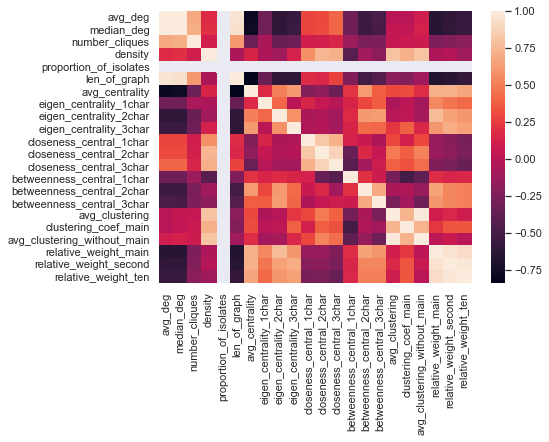

In [135]:
fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(X_scaled.corr())
plt.show()

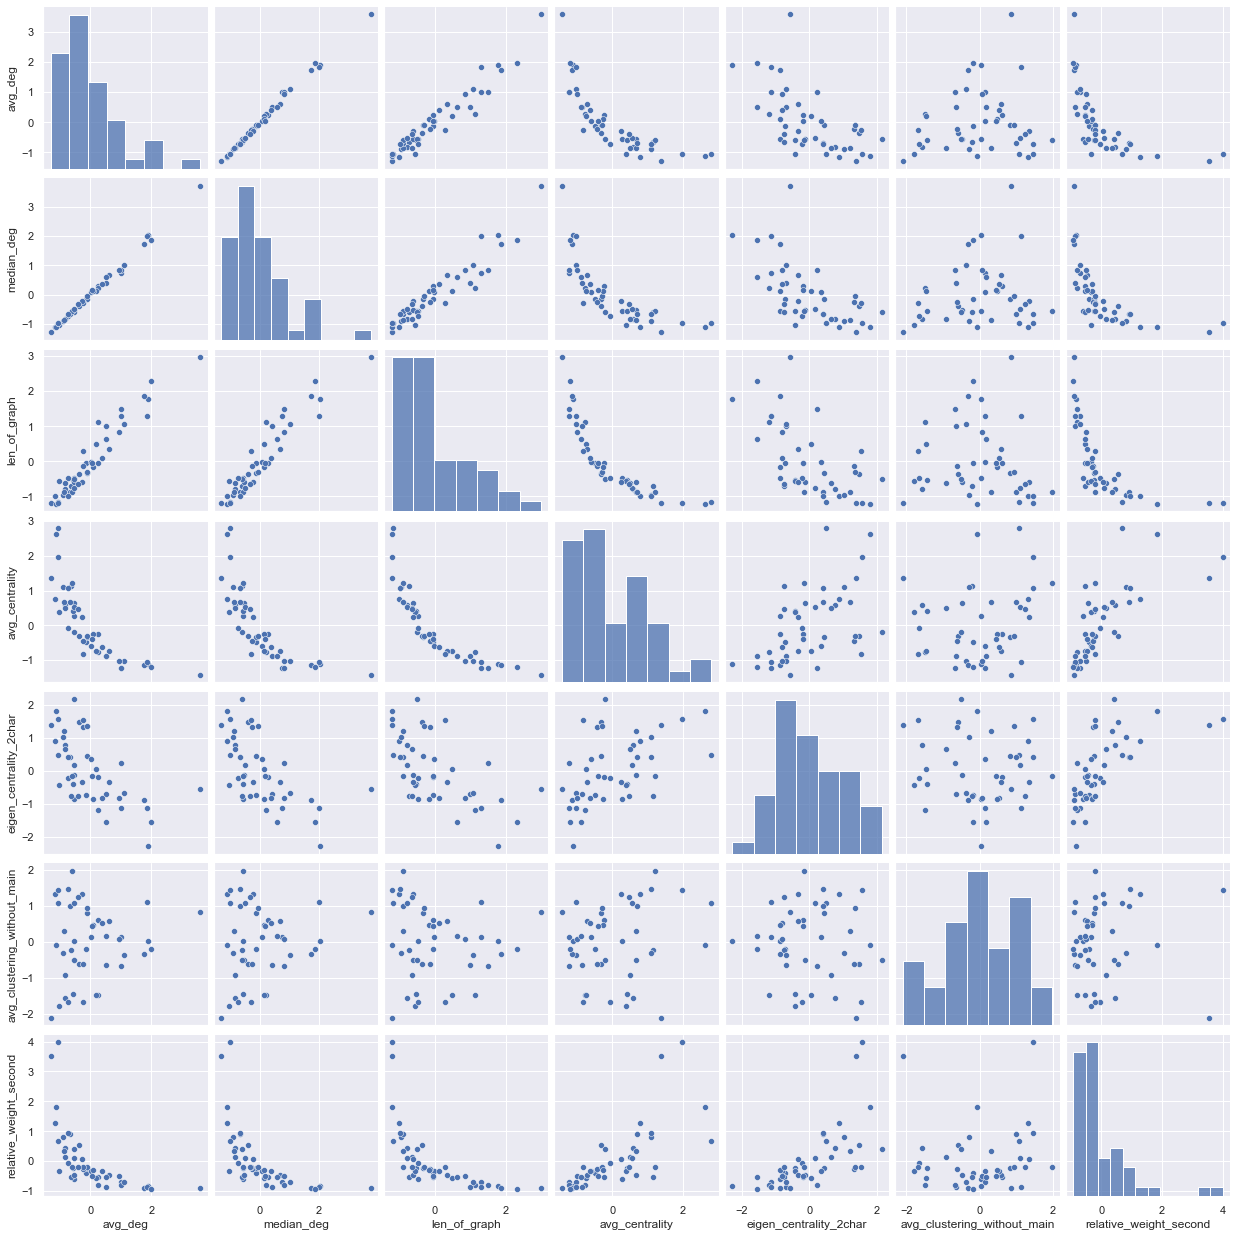

In [6]:
rand_cols = ['avg_deg', 'median_deg', 'len_of_graph', 'avg_centrality', 
             'eigen_centrality_2char', 'avg_clustering_without_main', 'relative_weight_second']
df_scatter = pd.DataFrame(X_scaled[rand_cols]).copy()
sns_plot = sns.pairplot(df_scatter)

__Analyse en Composantes Principales__

Grâce à la méthode du coude, regardons le nombre optimal de composantes à conserver, afin d'expliquer un maximum de variance.

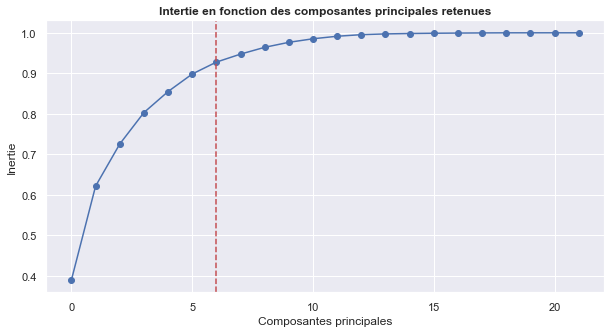

In [7]:
pca = PCA()
pca.fit(X_scaled)
explained_var = pca.explained_variance_ratio_

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range(0, len(explained_var)), explained_var.cumsum(), marker='o')
ax.set(xlabel = 'Composantes principales',
       ylabel = 'Inertie')
plt.axvline(x = 6, color='r', linestyle='--')
plt.title('Intertie en fonction des composantes principales retenues', fontweight='bold')
plt.show()

En retenant les 6 premières composantes principales, on explique plus de 90% de la variance du jeu de données.

In [146]:
# ACP avec données scalées
pca = PCA(n_components = 6)
pca_scaled_data = pca.fit_transform(X_scaled)

__Extractions pour WEKA__

In [160]:
path_WEKA = '/Users/simondelarue/Documents/MS_BGD-Telecom_PARIS/SD701_Exploration_Donnees/Projet/weka/input/'

# Données avec PCA
test = [df[['Author', 'Book']], pd.DataFrame(pca_scaled_data), df[['ind']]]
test2 = pd.concat(test, axis=1)
test2.to_csv(path_WEKA + r'df_pca.csv', index = False, header=True)

__KMeans__

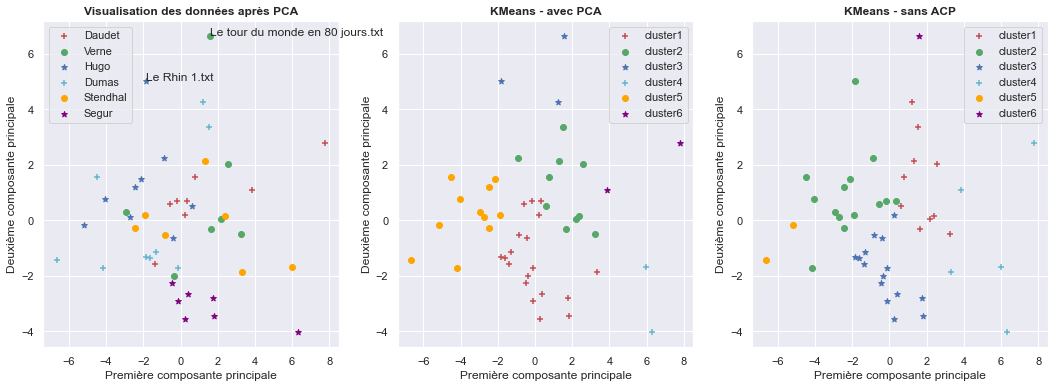

In [159]:
#https://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-clusters-in-a-k-means-unsupervised-learning-model/
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Visualisation des données après ACP
pca = PCA(n_components=2).fit(X_scaled)
pca_2d = pca.transform(X_scaled)
for i in range(0, pca_2d.shape[0]):
    if test2.ind[i] == 0:
        c1 = ax[0].scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif test2.ind[i] == 1:
        c2 = ax[0].scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif test2.ind[i] == 2:
        c3 = ax[0].scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
    elif test2.ind[i] == 3:
        c4 = ax[0].scatter(pca_2d[i, 0], pca_2d[i, 1], c='c', marker='+')
    elif test2.ind[i] == 4:
        c5 = ax[0].scatter(pca_2d[i, 0], pca_2d[i, 1], c='orange', marker='o')
    elif test2.ind[i] == 5:
        c6 = ax[0].scatter(pca_2d[i, 0], pca_2d[i, 1], c='purple', marker='*') 
        
ts = []
point1_y = test2.iloc[:, 3].max()
point1_x = test2[test2.columns[2]].loc[test2.iloc[:, 3].idxmax()]
point1_book = ' '.join(test2[test2.columns[1]].loc[test2.iloc[:, 3].idxmax()].split('_')[1:])
ts.append(ax[0].text(point1_x, point1_y, str(point1_book)))

point2_y = list(test2.iloc[:, 3].sort_values(ascending=False))[1]
point2_x = float(test2[test2[test2.columns[3]] == point2_y][test2.columns[2]])
point2_book = ' '.join(str(test2[test2[test2.columns[3]] == point2_y][test2.columns[1]]).split()[1].split('_')[1:])
ts.append(ax[0].text(point2_x, point2_y, str(point2_book)))
#adjust_text(ts, force_points=0.1, arrowprops=dict(arrowstyle='->', color='red'))
#ax[0].annotate('annotate', xy=(2, 1), xytext=(3, 4), arrowprops=dict(facecolor='r', shrink=0.05))
        
ax[0].legend([c1, c2, c3, c4, c5, c6], 
             list(test2.Author.unique()),
             loc = 'upper left')
ax[0].set(xlabel='Première composante principale', 
          ylabel='Deuxième composante principale')
ax[0].set_title('Visualisation des données après PCA', fontweight='bold')

# Visualisation des données pour KMeans après ACP
kmeans_clf = KMeans(n_clusters=6)
kmeans_clf.fit(pca_scaled_data)
for i in range(0, pca_2d.shape[0]):
    if kmeans_clf.labels_[i] == 0:
        c1 = ax[1].scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif kmeans_clf.labels_[i] == 1:
        c2 = ax[1].scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif kmeans_clf.labels_[i] == 2:
        c3 = ax[1].scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
    elif kmeans_clf.labels_[i] == 3:
        c4 = ax[1].scatter(pca_2d[i, 0], pca_2d[i, 1], c='c', marker='+')
    elif kmeans_clf.labels_[i] == 4:
        c5 = ax[1].scatter(pca_2d[i, 0], pca_2d[i, 1], c='orange', marker='o')
    elif kmeans_clf.labels_[i] == 5:
        c6 = ax[1].scatter(pca_2d[i, 0], pca_2d[i, 1], c='purple', marker='*')    
ax[1].legend([c1, c2, c3, c4, c5, c6], 
             ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6'],
            loc = 'upper right')
ax[1].set(xlabel='Première composante principale', 
          ylabel='Deuxième composante principale')
ax[1].set_title('KMeans - avec PCA', fontweight='bold')


# Visualisation des données pour KMeans sans ACP
kmeans_clf = KMeans(n_clusters=6)
kmeans_clf.fit(X_scaled)
for i in range(0, pca_2d.shape[0]):
    if kmeans_clf.labels_[i] == 0:
        c1 = ax[2].scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif kmeans_clf.labels_[i] == 1:
        c2 = ax[2].scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif kmeans_clf.labels_[i] == 2:
        c3 = ax[2].scatter(pca_2d[i, 0], pca_2d[i, 1], c='b', marker='*')
    elif kmeans_clf.labels_[i] == 3:
        c4 = ax[2].scatter(pca_2d[i, 0], pca_2d[i, 1], c='c', marker='+')
    elif kmeans_clf.labels_[i] == 4:
        c5 = ax[2].scatter(pca_2d[i, 0], pca_2d[i, 1], c='orange', marker='o')
    elif kmeans_clf.labels_[i] == 5:
        c6 = ax[2].scatter(pca_2d[i, 0], pca_2d[i, 1], c='purple', marker='*')    
ax[2].legend([c1, c2, c3, c4, c5, c6], ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6'])
ax[2].set(xlabel='Première composante principale', 
          ylabel='Deuxième composante principale') 
ax[2].set_title('KMeans - sans ACP', fontweight='bold')

plt.show()

## Annexes

### Tableau des oeuvres

In [79]:
nom_complet_df = pd.DataFrame([['Daudet', 'Alphonse Daudet'],
                              ['Verne', 'Jules Vernes'],
                              ['Hugo', 'Victor Hugo'],
                              ['Dumas', 'Alexandre Dumas'],
                              ['Stendhal', 'Stendhal'],
                              ['Segur', 'La comtesse de Segur']],
                             columns=['Nom short', 'Auteur'])

In [80]:
authors = []
books = []
for author, texts in file_dict.items():
    for text in texts:
        authors.append(author)
        books.append(' '.join(text.split('_')[1:]).split('.')[0])

In [81]:
df_author = pd.DataFrame(authors, columns=(['Nom short']))
df_livre = pd.DataFrame(books, columns=(['Oeuvre']))

In [83]:
oeuvres_df = pd.concat([df_author, df_livre], axis=1)
oeuvres_df = pd.merge(oeuvres_df, nom_complet_df, left_on='Nom short', right_on='Nom short')
del oeuvres_df['Nom short']
oeuvres_df = oeuvres_df.reindex(columns=['Auteur', 'Oeuvre'])
oeuvres_df

,Auteur,Oeuvre
0,Alphonse Daudet,Les femmes d artiste
1,Alphonse Daudet,La belle hivernaise
2,Alphonse Daudet,Le petit chose
3,Alphonse Daudet,Port Tarascon
4,Alphonse Daudet,Tartarin sur les Alpes
5,Alphonse Daudet,L immortel
6,Alphonse Daudet,Le nabab 2
7,Alphonse Daudet,Le nabab 1
8,Jules Vernes,Voyage au centre de la terre
9,Jules Vernes,L ile mysterieuse


### Analyse des TAG

% de mal classés pour le nom PER : 24.59%
% de bien classés pour le nom PER : 75.41%



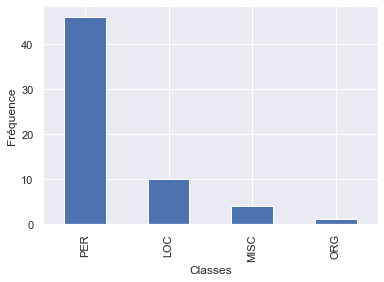

In [190]:
example = [word for word in tagged_text if (word[0]=="Danglars")]
calculate_tags_ratios(count_tags(example), example)
plot_hist_tags(count_tags(example))

### Analyse des text windows

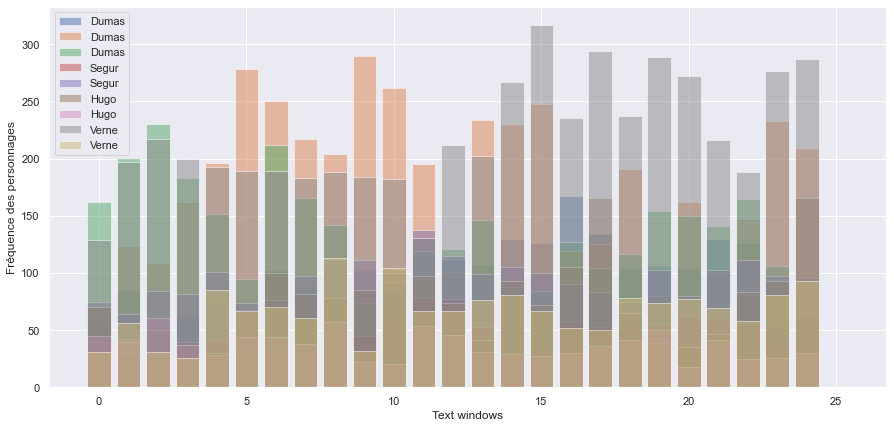

In [263]:
def plot_freq_characters(cleaned_text_windows):
    nb_livres = len(cleaned_text_windows)
    ax, fig = plt.subplots(1, 1, figsize=(15, 7))
    for num_livre, livre in enumerate(cleaned_text_windows):
        res = []
        for idx, elem in enumerate(livre):
            res.append(len(elem))
        plt.bar(range(0, len(livre)), res, label=liste_auteurs[num_livre], alpha=0.5)
    plt.xlabel('Text windows')
    plt.ylabel('Fréquence des personnages')
    plt.legend()
    plt.show()
plot_freq_characters(windows_tot)

### Analyse des networks 

__NetworkX__  
Ci-dessous des exemples des graphes créés pour 2 oeuvres sélectionnées au hasard.

Network Data saved!


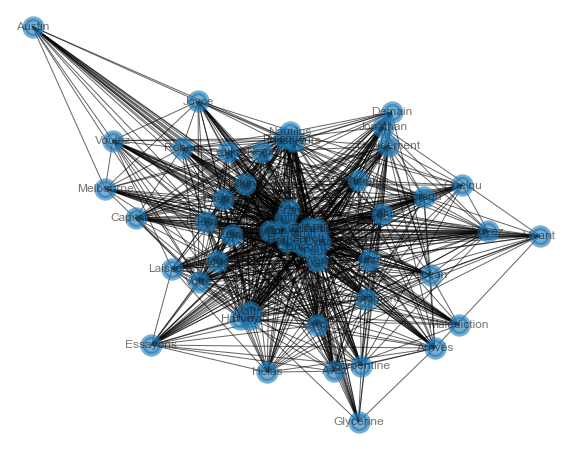

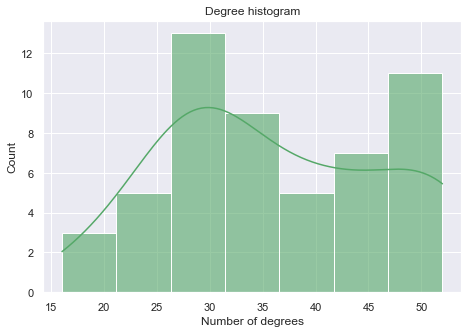

In [119]:
plot_pipeline(file_dict['Verne'][1])

Network Data saved!


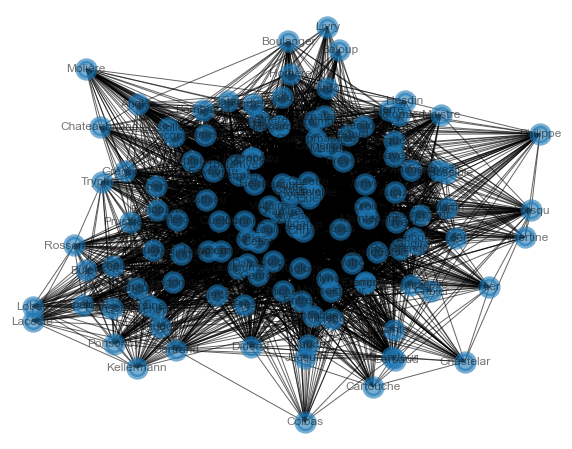

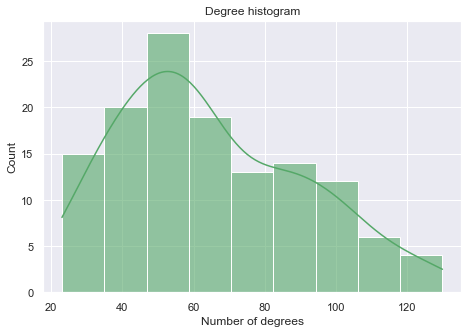

In [129]:
plot_pipeline(file_dict['Hugo'][5])

__Gephi__

Alexandre Dumas - Le comte de Monte Cristo

<img src="gephi_data/output/Dumas_Monte_Cristo.png" style="width:400px;height:400px"/>

La comtesse de Segur - Les malheurs de Sophie

<img src="gephi_data/output/Segur_Les_malheurs_de_Sophie.png" style="width:400px;height:400px"/>

### Analyse ACP

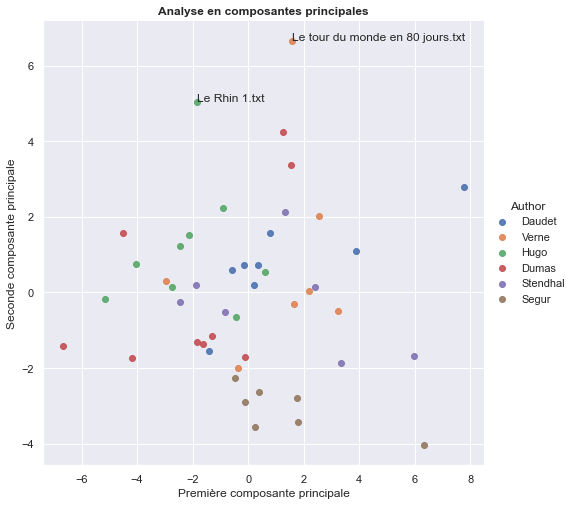

In [76]:
# Affichage des projections sur les deux premières composante principales
g = sns.FacetGrid(test2, hue='Author', height=7)
g.map(plt.scatter, test2.columns[2], test2.columns[3], alpha=0.9).add_legend()
g.ax.set_title('Analyse en composantes principales', fontweight="bold")
g.ax.set(xlabel = 'Première composante principale',
         ylabel = 'Seconde composante principale')

ts = []
point1_y = test2.iloc[:, 3].max()
point1_x = test2[test2.columns[2]].loc[test2.iloc[:, 3].idxmax()]
point1_book = ' '.join(test2[test2.columns[1]].loc[test2.iloc[:, 3].idxmax()].split('_')[1:])
ts.append(plt.text(point1_x, point1_y, str(point1_book)))

point2_y = list(test2.iloc[:, 3].sort_values(ascending=False))[1]
point2_x = float(test2[test2[test2.columns[3]] == point2_y][test2.columns[2]])
point2_book = ' '.join(str(test2[test2[test2.columns[3]] == point2_y][test2.columns[1]]).split()[1].split('_')[1:])
ts.append(plt.text(point2_x, point2_y, str(point2_book)))


#adjust_text(ts, force_points=0.1, arrowprops=dict(arrowstyle='->', color='red'))

plt.show()

### Tableau des features

In [47]:
# Detail des features
features_detail = pd.read_csv('features/features_detail.csv', delimiter=';')

# Construction de la table propre pour le rapport
features_df = pd.DataFrame(df.columns[2:], columns=['Feature_label'])
features_df = pd.merge(features_df, features_detail, left_on='Feature_label', right_on='Feature label')
del features_df['Feature_label']
features_df

,Feature label,Description
0,avg_deg,Degré moyen du graphe
1,median_deg,Degré médian du graphe
2,number_cliques,Nombre de cliques dans le graphe
3,density,Densité du graphe
4,proportion_of_isolates,Proportion de nœuds isolés dans le graphe
5,len_of_graph,Taille du graphe (i.e nombre de nœuds)
6,avg_centrality,Centralité moyenne du graphe
7,eigen_centrality_1char,Centralité la plus élevée dans le graphe
8,eigen_centrality_2char,2ème centralité la plus élevée
9,eigen_centrality_3char,3ème centralité la plus élevée


### Résultats from Weka

__Pureté__

Dans l'exercice présenté, on utilise la fonction __classes to clusters__ de WEKA ; à chaque cluster créé on associe le label correspondant au label de l'item le plus représénté dans le cluster.  
On peut alors calculer un _critère externe_, la __pureté__ ; pour chaque cluster créé via la méthode évoquée ci-dessus, on calcule le pourcentage d'éléments correctement classés et on divise par le nombre total d'éléments.

In [217]:
# instances classées de manière correctes = Pureté
weka_df = pd.DataFrame([['Sans ACP', 22, 48.94, 51.06, 72.34],
                       ['Avec ACP', 6, 34.03, 48.93, 72.34]],
                       columns=['ACP', 'Nb features', 'KMeans_incor', 'EM_incor', 'Hierarchical_Clustering_incor'])

weka_df['KMeans'] = round((100 - weka_df['KMeans_incor'])/100, 2)
weka_df['EM'] = round((100 - weka_df['EM_incor'])/100, 2)
weka_df['Hierarchical Clustering'] = round((100 - weka_df['Hierarchical_Clustering_incor'])/100, 2)
del weka_df['KMeans_incor']
del weka_df['EM_incor']
del weka_df['Hierarchical_Clustering_incor']
weka_df.set_index('ACP')

,Nb features,KMeans,EM,Hierarchical Clustering
ACP,,,,
Sans ACP,22,0.51,0.49,0.28
Avec ACP,6,0.66,0.51,0.28


__F1 Score__

In [25]:
# source formules de calcul https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html
weka_df2 = pd.DataFrame([['KMeans avec ACP', 6, 0.50, 0.57, 0.53],
                       ['EM avec ACP', 6, 0.38, 0.60, 0.46]],
                       columns=['Model', 'Nb features', 'Precision', 'Recall', 'F1_score'])
weka_df2 = weka_df2.set_index('Model')
weka_df2

,Nb features,Precision,Recall,F1_score
Model,,,,
KMeans avec ACP,6,0.50,0.57,0.53
EM avec ACP,6,0.38,0.60,0.46


## Sandbox

In [254]:
%%time

windows_tot = []

liste_textes = ['Dumas_La_tulipe_noire.txt', 'Dumas_Le_chevalier_de_maison_rouge.txt', 'Dumas_Le_comte_de_Monte_Cristo_1.txt',
               'Segur_Les_malheurs_de_Sophie.txt', 'Segur_Les_2_nigauds.txt', 
               'Hugo_Les_miserables_1.txt', 'Hugo_Napoleo_le_petit.txt',
               'Verne_L_ile_mysterieuse.txt', 'Verne_Vingt_mille_lieues_sous_les_mers.txt']
liste_auteurs = [elem.split('_')[0] for elem in liste_textes]

for text in liste_textes:
    essai = text
    print(essai)
    # Data Preprocessing
    file = read_file(essai)
    tokenized_file = tokenize(file, punctuations)
    cleaned_text = clean_text(tokenized_file, spacyNltk_stopwords_fr, pronoms_pers_fr)
    tagged_text = tagging(cleaned_text)
    TAG_df = clean_tag(tagged_text)

    clean_TAG_df = clean_df_TAG(TAG_df, 0.5) # treshold = 0.5 pour la proportion de catégorie maitresse
    second_clean_TAG_df = second_clean_tag(clean_TAG_df, tagged_text)

    text_windows = text_window(cleaned_text, 0.04) # Création des text windows 'brutes' de taille 4%
    cleaned_names = list(second_clean_TAG_df['cleanName'])
    cleaned_text_windows = [clean_text_window(text_window, cleaned_names) for text_window in text_windows] # Nettoyage des text windows
    
    windows_tot.append(cleaned_text_windows)

Dumas_La_tulipe_noire.txt
Dumas_Le_chevalier_de_maison_rouge.txt
Dumas_Le_comte_de_Monte_Cristo_1.txt
Segur_Les_malheurs_de_Sophie.txt
Segur_Les_2_nigauds.txt
Hugo_Les_miserables_1.txt
Hugo_Napoleo_le_petit.txt
Verne_L_ile_mysterieuse.txt
Verne_Vingt_mille_lieues_sous_les_mers.txt
CPU times: user 2min 35s, sys: 21.6 s, total: 2min 56s
Wall time: 3min
